# Data 6575: Deep Learning and AI Project Proposal  
## Forecasting Natural Gas Demand in Texas' Electric Power Sector Using LSTM

## Objective

The objective of this project is to predict next month’s natural gas consumption (measured in MMcf) for the electric-power sector in Texas. To accomplish this, I will train a standard Long Short-Term Memory (LSTM) neural network and a Bidirectional LSTM on ten years of historical monthly consumption data, augmented with engineered seasonal and temporal features and downloaded daily observation files for major airports added. I will then compare both models and evaluate its ability to produce accurate, data-driven forecasts.

## Background

Accurate short-term forecasting of natural gas demand in Texas’s electric-power sector is crucial because even small errors in predicting consumption can lead to costly imbalances, inefficient storage decisions, and missed trading opportunities in a market known for its high volatility. To tackle this, I assembled monthly natural gas delivery data from January 2014 through December 2024—sourced from a publicly available Kaggle dataset—and filtered it to Texas’s electric-power sector, where my employer CCI plays a major role. Recognizing that raw consumption figures alone cannot capture the complex seasonal and cyclical dynamics at play, I engineered a range of features: calendar indicators (month, quarter, year), lagged values at the 1-, 3-, and 12-month horizons, rolling three-month averages and standard deviations, and binary flags for winter and summer periods. I also added weather data from key locations throughout Texas to improve accuracy. By training an LSTM neural network on these enriched inputs, the model learns to identify recurring patterns and long-term dependencies, enabling trading desks to optimize hedge positions, grid operators to balance supply and demand more effectively, and for traders to refine its storage and delivery strategies—ultimately reducing costs and improving profitability in a fast-moving energy market. On a personal note, as I learn about the energy sector due to my new role, this project will both improve my technical coding skills and my domain knowledge, aiding my transition to the new role and hopefully impressing senior management.

Setup

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATA6575/Data6575_FinalProject_Data.csv')
df.head()

,year,month,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
0,2014,1,SFL,FLORIDA,EPG0,Natural Gas,VCS,Commercial Consumption,N3020FL2,Natural Gas Deliveries to Commercial Consumers...,6605.0,MMCF
1,2014,1,SNH,USA-NH,EPG0,Natural Gas,VCS,Commercial Consumption,N3020NH2,Natural Gas Deliveries to Commercial Consumers...,1691.0,MMCF
2,2014,1,SOR,USA-OR,EPG0,Natural Gas,VCS,Commercial Consumption,N3020OR2,Natural Gas Deliveries to Commercial Consumers...,4711.0,MMCF
3,2014,1,SDE,USA-DE,EPG0,Natural Gas,VCS,Commercial Consumption,N3020DE2,Natural Gas Deliveries to Commercial Consumers...,2128.0,MMCF
4,2014,1,SAZ,USA-AZ,EPG0,Natural Gas,VCS,Commercial Consumption,N3020AZ2,Natural Gas Deliveries to Commercial Consumers...,3915.0,MMCF


Preprocessing and Feature Engineering

In [3]:
df_tx_electric = df[
    (df['area-name'] == 'TEXAS') &
    (df['process-name'] == 'Electric Power Consumption')
].copy()

df_tx_electric['date'] = pd.to_datetime(dict(year=df_tx_electric.year, month=df_tx_electric.month, day=1))
df_tx_electric.sort_values('date', inplace=True)

df_tx_electric['value'] = df_tx_electric['value'].interpolate(method='linear')

df_tx_electric['month'] = df_tx_electric['date'].dt.month
df_tx_electric['year'] = df_tx_electric['date'].dt.year
df_tx_electric['quarter'] = df_tx_electric['date'].dt.quarter

df_tx_electric['lag_1'] = df_tx_electric['value'].shift(1)
df_tx_electric['lag_3'] = df_tx_electric['value'].shift(3)
df_tx_electric['lag_12'] = df_tx_electric['value'].shift(12)

df_tx_electric['rolling_mean_3'] = df_tx_electric['value'].rolling(window=3).mean()
df_tx_electric['rolling_std_3'] = df_tx_electric['value'].rolling(window=3).std()

df_tx_electric['is_winter'] = df_tx_electric['month'].isin([11, 12, 1, 2, 3]).astype(int)
df_tx_electric['is_summer'] = df_tx_electric['month'].isin([6, 7, 8]).astype(int)

df_tx_electric.dropna(inplace=True)
df_tx_electric.reset_index(drop=True, inplace=True)

print(df_tx_electric.head())

   year  month duoarea area-name product product-name process  \
0  2015      1     STX     TEXAS    EPG0  Natural Gas     VEU   
1  2015      2     STX     TEXAS    EPG0  Natural Gas     VEU   
2  2015      3     STX     TEXAS    EPG0  Natural Gas     VEU   
3  2015      4     STX     TEXAS    EPG0  Natural Gas     VEU   
4  2015      5     STX     TEXAS    EPG0  Natural Gas     VEU   

                 process-name    series  \
0  Electric Power Consumption  N3045TX2   
1  Electric Power Consumption  N3045TX2   
2  Electric Power Consumption  N3045TX2   
3  Electric Power Consumption  N3045TX2   
4  Electric Power Consumption  N3045TX2   

                                  series-description  ...  units       date  \
0  Texas Natural Gas Deliveries to Electric Power...  ...   MMCF 2015-01-01   
1  Texas Natural Gas Deliveries to Electric Power...  ...   MMCF 2015-02-01   
2  Texas Natural Gas Deliveries to Electric Power...  ...   MMCF 2015-03-01   
3  Texas Natural Gas Deliveries to

Imports and Reproducibility

In [4]:
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np, matplotlib.pyplot as plt
import urllib.request, os, datetime as dt
from math import pi

SEED   = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED);  np.random.seed(SEED)

Fetching and Cacheing Degree Days

In [5]:
STATIONS = {
    "USW00012960": "Houston IAH",
    "USW00012918": "Dallas Love Field",
    "USW00003927": "DFW International",
    "USW00012921": "San Antonio Intl Airport",
    "USW00013904": "Austin Bergstrom Intl Airport",
    "USW00012924": "Corpus Christi Intl Airport"
}

START_DATE = df_tx_electric["date"].min()
END_DATE   = df_tx_electric["date"].max()

def compute_deg_days(tmax_tenthC, tmin_tenthC):
    """Return HDD & CDD (°F base-65) from daily Tmax/Tmin in *tenths °C*."""
    tmax_f = tmax_tenthC / 10 * 9/5 + 32
    tmin_f = tmin_tenthC / 10 * 9/5 + 32
    tavg_f = (tmax_f + tmin_f) / 2
    hdd = max(0, 65 - tavg_f)
    cdd = max(0, tavg_f - 65)
    return hdd, cdd

def fetch_one_station(stn_id: str) -> pd.DataFrame:
    cache = f"{stn_id}_HDD_CDD.json"
    if os.path.exists(cache):
        return pd.read_json(cache, convert_dates=["date"])

    url  = f"https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/{stn_id}.dly"
    raw  = urllib.request.urlopen(url).read().decode()

    rows = []
    for line in raw.splitlines():
        elem = line[17:21].strip()
        year = int(line[11:15]);  month = int(line[15:17])

        if elem in ("HDD", "CDD"):
            for day in range(1, 32):
                val = int(line[21+(day-1)*8 : 26+(day-1)*8])
                if val == -9999: continue
                date = pd.Timestamp(year, month, day)
                rows.append({"date": date, "elem": elem, "value": val})
            continue

        if elem == "TMAX":
            tmax_vals = [int(line[21+(d-1)*8 : 26+(d-1)*8]) for d in range(1,32)]
        if elem == "TMIN":
            tmin_vals = [int(line[21+(d-1)*8 : 26+(d-1)*8]) for d in range(1,32)]
            for day,(tx,tn) in enumerate(zip(tmax_vals, tmin_vals), start=1):
                if tx == -9999 or tn == -9999: continue
                hdd,cdd = compute_deg_days(tx,tn)
                date = pd.Timestamp(year, month, day)
                rows.extend([{"date":date, "elem":"HDD", "value":hdd},
                             {"date":date, "elem":"CDD", "value":cdd}])

    if not rows:
        raise RuntimeError(f"{stn_id}: could not derive HDD/CDD")

    df = (pd.DataFrame(rows)
            .pivot_table(index="date", columns="elem", values="value", aggfunc="sum")
            .resample("MS").sum()
            .reset_index())

    df.to_json(cache)
    return df

dfs = []
for stn_id, name in STATIONS.items():
    print(f"⇣  Processing {name} ({stn_id})")
    dfs.append(fetch_one_station(stn_id).set_index("date"))

df_dd = (pd.concat(dfs, axis=1)
           .groupby(level=0).mean()
           .reset_index()
           .loc[lambda d: (d["date"]>=START_DATE)&(d["date"]<=END_DATE)])

print("Weather frame:", df_dd.shape)
print(df_dd.head(), "\n", df_dd.tail())

⇣  Processing Houston IAH (USW00012960)
⇣  Processing Dallas Love Field (USW00012918)
⇣  Processing DFW International (USW00003927)
⇣  Processing San Antonio Intl Airport (USW00012921)
⇣  Processing Austin Bergstrom Intl Airport (USW00013904)
⇣  Processing Corpus Christi Intl Airport (USW00012924)
Weather frame: (109, 13)
elem       date     CDD     HDD     CDD     HDD     CDD     HDD     CDD  \
1013 2015-01-01    0.00  470.04    0.00  445.92    0.00  633.48    0.00   
1014 2015-02-01    8.91  356.91    9.42  319.08    0.00  540.06   11.46   
1015 2015-03-01   65.13  142.95   69.69  118.53   31.89  306.63   51.87   
1016 2015-04-01  228.09    4.53  239.76    0.00   83.13   59.91  209.49   
1017 2015-05-01  370.74    0.00  396.66    0.00  189.93    7.02  351.48   

elem     HDD     CDD     HDD     CDD     HDD  
1013  479.13    0.00  586.50    2.94  397.74  
1014  343.26    1.56  442.80   23.49  236.40  
1015  178.47   34.74  245.31   70.17  119.37  
1016    9.06  162.87   26.97  273.84 

Aggregating Weather Data

In [6]:
df_dd = (
    pd.concat(dfs, axis=1)
      .groupby(level=0, axis=1).mean()
      .reset_index()
      .loc[lambda d: (d["date"]>=START_DATE) & (d["date"]<=END_DATE)]
)
print(df_dd.head(), "\n", df_dd.tail())

elem       date      CDD      HDD
1013 2015-01-01    0.490  502.135
1014 2015-02-01    9.140  373.085
1015 2015-03-01   53.915  185.210
1016 2015-04-01  199.530   16.830
1017 2015-05-01  337.515    1.170 
 elem       date      CDD      HDD
1117 2023-09-01  624.285    0.000
1118 2023-10-01  280.460   44.765
1119 2023-11-01   57.765  172.575
1120 2023-12-01   15.695  255.485
1121 2024-01-01    2.605  479.605


/tmp/ipython-input-6-2776522020.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(level=0, axis=1).mean()


In [7]:
def enrich_with_weather(gas_df, weather_df):
    out = (gas_df.merge(weather_df, on="date", how="left")
                  .fillna(method="ffill"))
    out["sin_month"] = np.sin(2*pi*out["month"]/12)
    out["cos_month"] = np.cos(2*pi*out["month"]/12)
    return out

df_tx_enriched = enrich_with_weather(df_tx_electric, df_dd)
df_tx_enriched.head()

/tmp/ipython-input-7-1620591416.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="ffill"))


,year,month,duoarea,area-name,product,product-name,process,process-name,series,series-description,...,lag_3,lag_12,rolling_mean_3,rolling_std_3,is_winter,is_summer,CDD,HDD,sin_month,cos_month
0,2015,1,STX,TEXAS,EPG0,Natural Gas,VEU,Electric Power Consumption,N3045TX2,Texas Natural Gas Deliveries to Electric Power...,...,118033.0,107671.0,111493.333333,13457.445015,1,0,0.490,502.135,0.500000,8.660254e-01
1,2015,2,STX,TEXAS,EPG0,Natural Gas,VEU,Electric Power Consumption,N3045TX2,Texas Natural Gas Deliveries to Electric Power...,...,100467.0,94715.0,115845.000000,9693.557293,1,0,9.140,373.085,0.866025,5.000000e-01
2,2015,3,STX,TEXAS,EPG0,Natural Gas,VEU,Electric Power Consumption,N3045TX2,Texas Natural Gas Deliveries to Electric Power...,...,107524.0,94692.0,122420.666667,7715.883769,1,0,53.915,185.210,1.000000,6.123234e-17
3,2015,4,STX,TEXAS,EPG0,Natural Gas,VEU,Electric Power Consumption,N3045TX2,Texas Natural Gas Deliveries to Electric Power...,...,126489.0,99834.0,119352.000000,7094.500053,0,0,199.530,16.830,0.866025,-5.000000e-01
4,2015,5,STX,TEXAS,EPG0,Natural Gas,VEU,Electric Power Consumption,N3045TX2,Texas Natural Gas Deliveries to Electric Power...,...,113522.0,111872.0,122295.333333,4984.241601,0,0,337.515,1.170,0.500000,-8.660254e-01


Windowing and Dataloaders

In [8]:
LOOK_BACK = 12
BATCH_SIZE = 32
TARGET = "value"

NEW_FEATURES = [
    "lag_1","lag_3","lag_12",
    "rolling_mean_3","rolling_std_3",
    "HDD","CDD",
    "sin_month","cos_month"
]

def seq_arrays(df, look_back=LOOK_BACK):
    sx = StandardScaler().fit(df[NEW_FEATURES])
    sy = StandardScaler().fit(df[[TARGET]])
    X = sx.transform(df[NEW_FEATURES]).astype("float32")
    y = sy.transform(df[[TARGET]]).astype("float32").flatten()
    X_seq, y_seq = [], []
    for i in range(len(df)-look_back):
        X_seq.append(X[i:i+look_back])
        y_seq.append(y[i+look_back])
    return np.array(X_seq), np.array(y_seq), sx, sy

split = int(0.8*len(df_tx_enriched))
X_tr,y_tr,scaler_X,scaler_y = seq_arrays(df_tx_enriched.iloc[:split])
X_vl,y_vl,_,_               = seq_arrays(df_tx_enriched.iloc[split:])

train_dl = DataLoader(TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr)),
                      batch_size=BATCH_SIZE, shuffle=True)
val_dl   = DataLoader(TensorDataset(torch.from_numpy(X_vl), torch.from_numpy(y_vl)),
                      batch_size=BATCH_SIZE)
print("n_feats:", X_tr.shape[-1], "   train batches:", len(train_dl))

n_feats: 9    train batches: 3


Model Definitions

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ———————————————————————————————
# 1) Original “Baseline” LSTM
# ———————————————————————————————
class BaselineLSTM(nn.Module):
    def __init__(self, n_feats, hidden=128, layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size   = n_feats,
            hidden_size  = hidden,
            num_layers   = layers,
            batch_first  = True,
            dropout      = dropout
        )
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last   = out[:, -1, :]
        return self.fc(last).squeeze()


# ———————————————————————————————
# 2) “Improved” Bidirectional + LayerNorm LSTM
# ———————————————————————————————
class BidirectionalLSTM(nn.Module):
    def __init__(self, n_feats, hidden=256, layers=3, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size    = n_feats,
            hidden_size   = hidden,
            num_layers    = layers,
            batch_first   = True,
            dropout       = dropout,
            bidirectional = True
        )
        self.norm = nn.LayerNorm(hidden * 2)
        self.head = nn.Sequential(
            nn.Linear(hidden * 2, hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last   = out[:, -1, :]
        return self.head(self.norm(last)).squeeze()

Training and Evaluation

In [10]:
def evaluate(model, data_loader, scaler_y):
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for xb, yb in data_loader:
            xb = xb.to(DEVICE)
            out = model(xb).cpu().numpy().ravel()
            all_preds.extend(out.tolist())
            all_trues.extend(yb.numpy().tolist())

    preds = scaler_y.inverse_transform(np.array(all_preds).reshape(-1,1)).ravel()
    trues = scaler_y.inverse_transform(np.array(all_trues).reshape(-1,1)).ravel()

    mae  = mean_absolute_error(trues, preds)
    mape = mean_absolute_percentage_error(trues, preds)
    return mae, mape, preds, trues


def train_model(model, train_dl, val_dl, scaler_y,
                lr=1e-3, epochs=30, patience=6):
    model.to(DEVICE)
    loss_fn = nn.MSELoss()

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = OneCycleLR(
        optimizer, max_lr=lr,
        steps_per_epoch=len(train_dl),
        epochs=epochs,
        pct_start=0.2
    )

    best_mae      = float("inf")
    best_state    = None
    patience_left = patience

    for epoch in range(1, epochs+1):
        model.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

        mae, mape, _, _ = evaluate(model, val_dl, scaler_y)
        print(f"Ep {epoch:02d} — MAE {mae:,.0f}  MAPE {mape:.2%}")

        if mae + 1e-3 < best_mae:
            best_mae      = mae
            best_state    = model.state_dict()
            patience_left = patience
        else:
            patience_left -= 1
            if patience_left == 0:
                print(f"Early stopping at epoch {epoch}")
                model.load_state_dict(best_state)
                break

    return model

Train Baseline Model

In [11]:
n_in = X_tr.shape[-1]
baseline = BaselineLSTM(n_feats=n_in)
baseline = train_model(
    baseline,
    train_dl,
    val_dl,
    scaler_y,
    lr=1e-3,
    epochs=30,
    patience=6
)

Ep 01 — MAE 29,810  MAPE 19.87%
Ep 02 — MAE 29,654  MAPE 19.79%
Ep 03 — MAE 29,340  MAPE 19.63%
Ep 04 — MAE 28,807  MAPE 19.34%
Ep 05 — MAE 27,971  MAPE 18.86%
Ep 06 — MAE 26,218  MAPE 17.80%
Ep 07 — MAE 22,743  MAPE 15.73%
Ep 08 — MAE 16,206  MAPE 12.25%
Ep 09 — MAE 18,790  MAPE 14.12%
Ep 10 — MAE 17,983  MAPE 13.16%
Ep 11 — MAE 11,482  MAPE 8.38%
Ep 12 — MAE 10,394  MAPE 7.50%
Ep 13 — MAE 10,932  MAPE 7.87%
Ep 14 — MAE 10,345  MAPE 7.74%
Ep 15 — MAE 11,024  MAPE 8.10%
Ep 16 — MAE 10,139  MAPE 7.42%
Ep 17 — MAE 9,547  MAPE 6.92%
Ep 18 — MAE 9,189  MAPE 6.62%
Ep 19 — MAE 9,281  MAPE 6.61%
Ep 20 — MAE 9,515  MAPE 6.73%
Ep 21 — MAE 9,618  MAPE 6.81%
Ep 22 — MAE 9,228  MAPE 6.62%
Ep 23 — MAE 8,868  MAPE 6.44%
Ep 24 — MAE 8,936  MAPE 6.47%
Ep 25 — MAE 8,960  MAPE 6.48%
Ep 26 — MAE 8,899  MAPE 6.45%
Ep 27 — MAE 8,849  MAPE 6.43%
Ep 28 — MAE 8,825  MAPE 6.43%
Ep 29 — MAE 8,821  MAPE 6.43%
Ep 30 — MAE 8,821  MAPE 6.43%


Train Bidirectional LSTM

In [12]:
improved = BidirectionalLSTM(n_feats=n_in)
improved = train_model(
    improved,
    train_dl,
    val_dl,
    scaler_y,
    lr=1e-3,
    epochs=30,
    patience=6
)

Ep 01 — MAE 27,835  MAPE 18.86%
Ep 02 — MAE 24,951  MAPE 16.66%
Ep 03 — MAE 18,434  MAPE 14.22%
Ep 04 — MAE 14,516  MAPE 11.08%
Ep 05 — MAE 16,772  MAPE 11.12%
Ep 06 — MAE 20,957  MAPE 15.37%
Ep 07 — MAE 15,405  MAPE 10.86%
Ep 08 — MAE 13,451  MAPE 10.11%
Ep 09 — MAE 11,478  MAPE 7.86%
Ep 10 — MAE 16,610  MAPE 12.12%
Ep 11 — MAE 9,589  MAPE 7.19%
Ep 12 — MAE 8,948  MAPE 6.35%
Ep 13 — MAE 13,007  MAPE 9.01%
Ep 14 — MAE 14,963  MAPE 10.95%
Ep 15 — MAE 8,965  MAPE 6.48%
Ep 16 — MAE 15,386  MAPE 10.93%
Ep 17 — MAE 8,962  MAPE 6.32%
Ep 18 — MAE 10,533  MAPE 7.48%
Early stopping at epoch 18


Model Evaluation

In [13]:
mae_b, mape_b, preds_b, trues_b = evaluate(baseline, val_dl, scaler_y)
mae_i, mape_i, preds_i, trues_i = evaluate(improved, val_dl, scaler_y)

print(f"Baseline  →  MAE={mae_b:.0f},  MAPE={mape_b:.2%}")
print(f"Improved  →  MAE={mae_i:.0f},  MAPE={mape_i:.2%}")

Baseline  →  MAE=8821,  MAPE=6.43%
Improved  →  MAE=10533,  MAPE=7.48%


Summary Table

In [14]:
df_summary = pd.DataFrame({
    "Model":    ["Baseline", "Improved"],
    "MAE":      [mae_b,       mae_i],
    "MAPE (%)": [mape_b*100,  mape_i*100]
})
df_summary.set_index("Model", inplace=True)
df_summary

,MAE,MAPE (%)
Model,,
Baseline,8820.624144,6.425239
Improved,10532.788921,7.476308


Final Comparison - Visualisation

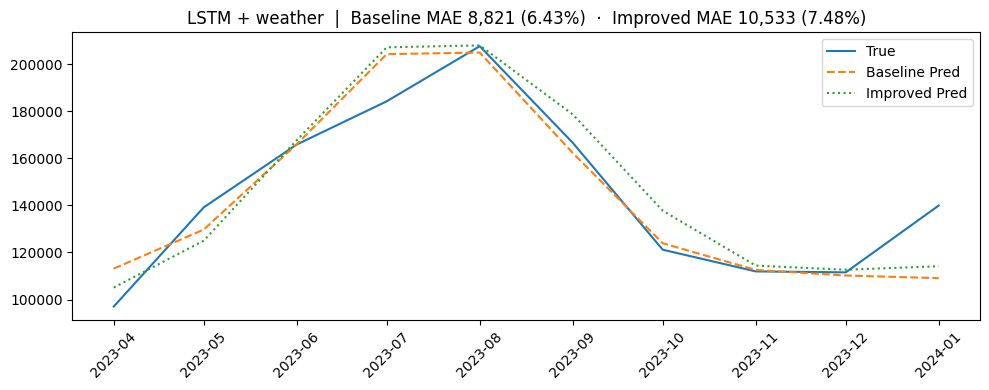

In [15]:
dates_val = df_tx_enriched["date"].iloc[LOOK_BACK+split :].tolist()

mae_b, mape_b, preds_b, trues   = evaluate(baseline,  val_dl, scaler_y)
mae_i, mape_i, preds_i, _       = evaluate(improved, val_dl, scaler_y)

plt.figure(figsize=(10,4))
plt.plot(dates_val, trues,   label="True")
plt.plot(dates_val, preds_b, label="Baseline Pred", linestyle="--")
plt.plot(dates_val, preds_i, label="Improved Pred",  linestyle=":")
plt.title(
    f"LSTM + weather  |  "
    f"Baseline MAE {mae_b:,.0f} ({mape_b:.2%})  ·  "
    f"Improved MAE {mae_i:,.0f} ({mape_i:.2%})"
)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Business Interpretation

I used two forecasting models for this assignment, one a "straightforward" LSTM and a "enhanced" Bidirectional LSTM. I have included explanations of both below.

1. **Baseline (Straightforward) Model**  
   - **Architecture**: A single‐directional LSTM that reads past monthly demand in time order—from oldest to newest.  
   - **Strength**: Focuses on clear, easily interpretable patterns (e.g. the last 1, 3 or 12 months of usage) without overcomplicating calculations.  
   - **Performance**: Achieved an average error of **8,800 MWh** (≈ 6.4%), demonstrating that a lean, focused approach can capture most of the signal in our data.

2. **Enhanced (Bidirectional) Model**  
   - **Architecture**: A bidirectional LSTM with Layer Normalization and a deeper two-layer output network. This reads the sequence forwards *and* backwards, then combines both views before making a prediction.  
   - **Intended Benefit**: By examining recent and slightly older data together, it aims to pick up subtler dependencies—especially when demand patterns aren’t strictly forward‐looking.  
   - **Outcome**: Despite its sophistication, it averaged a larger error of **10,500 MWh** (≈ 7.5%). This suggests that, for our ten-year monthly series, the extra flexibility introduced more noise than signal.

### Why the simpler model won out

- **Data Volume**: With only ~120 months of history, over-parameterized models can “overfit” noise rather than learn true demand drivers. Overfitting occurs when a model learns the random noise in its training data instead of just the real underlying patterns. As a result, it performs very well on past data but poorly on new, unseen data.
- **Signal-to-Noise Ratio**: Electricity demand is influenced by strong, consistent seasonal and weather patterns that a straightforward model already captures well.  
- **Maintainability**: Fewer moving parts mean faster retraining, easier troubleshooting, and more transparent results for stakeholders.

In summary, while the enhanced model’s bidirectional structure looked promising on paper, the baseline model’s focused design delivered better real-world accuracy—and does so with less complexity and greater interpretability.  



## Business Context

A 6.4% margin of error means that monthly demand forecasts will, on average, fall within ±6.4% of actual usage. For a comodities merchant, where each percentage point of mis‐forecast can translate into millions in fuel and procurement variance - this level of precision is **reliable** and **actionable**:

- **Budget Certainty**  
  Finance teams can set hedging and purchasing limits with confidence, reducing exposure to costly spot-market swings and penalty charges.  

- **Operational Efficiency**  
  Grid and field crews can plan maintenance windows and staffing rosters to match true demand peaks, cutting overtime and emergency-call-out costs.  

- **Risk Reduction**  
  Early warning of potential under- or over-supply allows risk managers to allocate reserves more judiciously, preserving reliability without over-investing in backup assets.  

In practice, a sub-7% error band is well within industry tolerances for monthly energy planning. Deploying this model gives a commodity merchant a **usable**, **scalable** forecasting tool that drives leaner budgets, smoother operations, and stronger risk control - delivering immediate bottom-line value without the complexity or uncertainty of more elaborate methods.  